# Capsule V1

This implementation doesn't have the decoder structure.

> Dynamic Routing Between Capsules. [arXiv:1710.09829v1](https://arxiv.org/abs/1710.09829)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from torchvision import datasets

## Load MINST Data

- download mnist dataset
    - [http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz)
- extract them to a directory

In [3]:
trainImage = datasets.mnist.read_image_file('../Dataset/MNIST/train-images.idx3-ubyte')
trainLabel = datasets.mnist.read_label_file('../Dataset/MNIST/train-labels.idx1-ubyte')
trainImage = trainImage.float() / 255
trainLabel = trainLabel.reshape(-1,1)

N,W,H = trainImage.shape
trainImage = torch.reshape(trainImage, (N,1,W,H))
print(trainImage.shape)
del N,W,H

torch.Size([60000, 1, 28, 28])


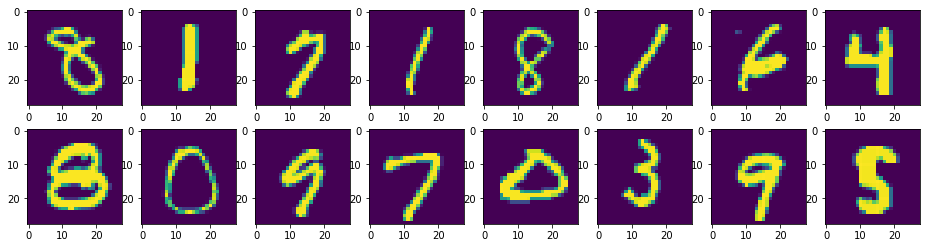

In [4]:
tinp = np.random.choice(trainImage.shape[0], (16,))
tinp = trainImage.data.numpy()[tinp]
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(tinp[i,0])
plt.show()

## Capsule 

- low-layer capsule $\rightarrow$ hight-layer 
- 

### Squashing 

$$
\begin{array}{cc}
v_j = \dfrac{\|s_j\|^2}{1 + \|s_j\|^2} \dfrac{s_j}{\|s_j\|},&
\|s_j\| = \sqrt{\|s_j\|^2_F}
\end{array}
$$

In [5]:
def squashing(s):
    """
    Input:
    - s: (batch, atoms, output_dim)
    Return:
    - v
    """
    vec_squ = torch.sum(s * s, 2, keepdim=True)
    vec_sum = torch.sqrt(vec_squ)
    vec_v = (s * vec_sum) / (1 + vec_squ)
    return vec_v

### Routing algorithm

$$s_j = \sum_i c_{ij} \hat{u}_{j|i}, \quad \hat{u}_{j|i} = W_{ij} u_i$$

$$c_{ij} = \dfrac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}$$

In [6]:
def routing(priors, output_dim, iteration=3):
    """
    batch, input_dim, output_dim, output_atoms
    Input:
    - hatu: (batch, input_dim, atoms) $w \cdot u$
    - nextlayer: a number 
    - iteration: usually 3
    """
    logits = torch.zeros(*priors.shape)
    for i in range(iteration-1):
        probs = F.softmax(logits, dim=2)
        outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
        delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
        logits = logits + delta_logits
    probs = F.softmax(logits, dim=2)
    outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
    return outputs

### Capsule Model

In [7]:
class CapsuleModule(nn.Module):
    def __init__(self):
        super(CapsuleModule, self).__init__()
        self.conv1 = nn.Conv2d(1,512, (9,9), stride=1)
        self.primary_capsule = nn.Conv2d(512, 32*8, (9,9), stride=2, groups=32*8)

        # num_capsules, 1, num_route_nodes, in_channels, out_channels
        self.w = Parameter(torch.Tensor(10, 1, 32*6*6, 8, 16).normal_())
        
    def forward(self, x):
        """
        Output:
            [batch, output_dim, output_atoms]
        """
        out = F.leaky_relu(self.conv1(x), 0.02) # first layer
        # out (batch,32,6,6)
        out = self.primary_capsule(out) # primary capsule  
        out = torch.transpose(out.view(1, -1, 8, 32*6*6, 1), 2,3)
        priors = torch.sum(out * self.w, dim=3)
        out = routing(priors, 10, 3).squeeze().transpose(0,1)
        classes = torch.sqrt((out * out).sum(dim=-1))
        classes = F.softmax(classes, dim=-1)
        return classes


### Margin Loss

$$L_c = T_c \max(0,m^+ - \|v_c\|)^2 + \lambda (1 - T_c) \max(0, \|v_c\| - m^-)^2$$

In [8]:
def margin_loss(classes, target, mplus=0.9, mminus=0.1, l=0.5):
    """
    - vc: module output, (N,L,J)
    - target: one hot label
    - mplus: $m^+$
    - mminus: $m^-$
    - l: $lambda$
    """
    thezero = torch.zeros_like(classes)
    Lc1 = torch.where(mplus > classes, mplus-classes, thezero)
    Lc2 = torch.where(mminus < classes, classes-mminus, thezero)
    Lc = target * (Lc1*Lc1) + l*(1.0-target)*(Lc2*Lc2)
    return torch.mean(Lc)

### Train

In [9]:
capsule = CapsuleModule()
optim = torch.optim.Adam(capsule.parameters(), lr=1e-3)

In [10]:
# 60000 images
for epho in range(1):
    for i in range(0,50000,500):
        tImage = trainImage[i:i+500]
        tLabel = torch.zeros(500, 10).scatter_(1, trainLabel[i:i+500], 1)
        optim.zero_grad()
        classes = capsule(tImage)
        loss = margin_loss(classes, tLabel)
        loss.backward()
        optim.step()
        print("epho {:04d}, offset {:05d}, loss {:.8f}".format(epho, i, loss))

epho 0000, offset 0000, loss 0.06400035
epho 0000, offset 0500, loss 0.06399973
epho 0000, offset 1000, loss 0.06399838
epho 0000, offset 1500, loss 0.06399673
epho 0000, offset 2000, loss 0.06399503
epho 0000, offset 2500, loss 0.06399271
epho 0000, offset 3000, loss 0.06398952
epho 0000, offset 3500, loss 0.06398597
epho 0000, offset 4000, loss 0.06397830
epho 0000, offset 4500, loss 0.06397027
epho 0000, offset 5000, loss 0.06394646
epho 0000, offset 5500, loss 0.06393398
epho 0000, offset 6000, loss 0.06389461
epho 0000, offset 6500, loss 0.06385339
epho 0000, offset 7000, loss 0.06386207
epho 0000, offset 7500, loss 0.06361863
epho 0000, offset 8000, loss 0.06311736
epho 0000, offset 8500, loss 0.06248755
epho 0000, offset 9000, loss 0.06246744
epho 0000, offset 9500, loss 0.06121963
epho 0000, offset 10000, loss 0.06220530
epho 0000, offset 10500, loss 0.06196919
epho 0000, offset 11000, loss 0.05987598
epho 0000, offset 11500, loss 0.05831876
epho 0000, offset 12000, loss 0.0574

### test output

In [17]:
tout = capsule(trainImage[50000:50000+100])
capout = torch.argmax(tout,dim=1)
print(capout)

tensor([3, 8, 6, 9, 6, 4, 4, 5, 8, 4, 5, 2, 3, 8, 4, 8, 8, 5, 0, 5, 9, 7, 4, 1,
        0, 6, 0, 6, 2, 7, 9, 4, 1, 5, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 2, 7,
        8, 4, 4, 1, 4, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5,
        0, 6, 9, 7, 6, 8, 5, 9, 4, 0, 6, 1, 4, 2, 2, 8, 7, 4, 9, 4, 6, 6, 1, 7,
        2, 8, 6, 7])


In [ ]:
actlabel = trainLabel[50000:50000+100,0]
print(actlabel)

In [ ]:
print(torch.sum(capout == actlabel))